# Modelization 
For this analysis, let's consider a range of regression models:

* Linear Regression: A simple baseline model.
* Ridge Regression: Linear regression with L2 regularization.
* Lasso Regression: Linear regression with L1 regularization.
* Random Forest Regressor: A decision tree-based ensemble method.
* Gradient Boosting Regressor: Boosting-based ensemble method.

We will also perform a time series modelization. It will allow us to predict how the UPDRS scores will evolve over time for new patients for same medication or off medication.

* Exponential smoothing 
* Autoregressive integrated moving average (ARIMA)

#### 1. Getting the pre-processed data

In [2]:
%run utilspro.py

In [ ]:
%run "3_data_preprocessing.ipynb"
#execute_notebook("3_data_preprocessing.ipynb")

## Setting up the pipelines

In [4]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

# Create pipelines for each model
pipelines = {name: Pipeline([('model', model)]) for name, model in models.items()}

# Train and evaluate each pipeline
results = {}
for name, pipeline in pipelines.items():
    # Train the model
    pipeline.fit(X_train_scaled, y_train)
    
    # Predict on the test set
    predictions = pipeline.predict(X_test_scaled)
    
    # Compute the mean squared error
    mse = mean_squared_error(y_test, predictions)
    results[name] = mse

results


{'Linear Regression': 96.72539177942704,
 'Ridge Regression': 96.80781600694735,
 'Lasso Regression': 97.24170054684595,
 'Random Forest Regressor': 99.14816629889401,
 'Gradient Boosting Regressor': 85.90483782690822}

The Gradient Boosting Regressor has the lowest MSE, making it the best-performing model among the ones we evaluated.

### Hyper parameter tuning

let's focus on hyperparameter tuning for the best-performing model, which is the Gradient Boosting Regressor

* n_estimators: The number of boosting stages to be run.
* learning_rate: Determines the contribution of each tree to the final prediction.
* max_depth: The maximum depth of the individual regression estimators.
* min_samples_split: The minimum number of samples required to split an internal node.
* min_samples_leaf: The minimum number of samples required to be at a leaf node.

We will define a grid for these hyperparameters and perform a grid search to find the best combination.

In [ ]:
# Define the hyperparameter grid for Gradient Boosting Regressor
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Create a GridSearchCV object for Gradient Boosting Regressor
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

best_params, best_score

({'learning_rate': 0.1,
  'max_depth': 4,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 50},
 77.36852687070196)

In [ ]:
# Define a reduced hyperparameter grid for Gradient Boosting Regressor
reduced_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Create a GridSearchCV object for Gradient Boosting Regressor with reduced grid
reduced_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), reduced_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model with reduced grid
reduced_grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the corresponding score from the reduced grid search
reduced_best_params = reduced_grid_search.best_params_
reduced_best_score = -reduced_grid_search.best_score_

reduced_best_params, reduced_best_score

({'learning_rate': 0.1,
  'max_depth': 3,
  'min_samples_leaf': 1,
  'min_samples_split': 4,
  'n_estimators': 100},
 77.84541133733364)

In [ ]:
# Create a RandomizedSearchCV object for Gradient Boosting Regressor
random_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Fit the model with random search
random_search.fit(X_train_scaled, y_train)

# Get the best parameters and the corresponding score from the randomized search
random_best_params = random_search.best_params_
random_best_score = -random_search.best_score_

random_best_params, random_best_score

({'n_estimators': 150,
  'min_samples_split': 4,
  'min_samples_leaf': 1,
  'max_depth': 3,
  'learning_rate': 0.1},
 79.00452234510185)

In [ ]:
refined_param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5, 1],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 4, 6, 8, 10, 0.01, 0.05, 0.1, 0.2, 0.3],
    'min_samples_leaf': [1, 2, 3, 4, 5, 0.01, 0.05, 0.1, 0.2]
}
# Create a GridSearchCV object for Gradient Boosting Regressor with refined grid
refined_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), refined_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model with reduced grid
refined_grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the corresponding score from the reduced refined grid search

refined_best_params = refined_grid_search.best_params_
refined_best_score = refined_grid_search.best_score_

refined_best_params, refined_best_score

({'learning_rate': 0.05,
  'max_depth': 6,
  'min_samples_leaf': 4,
  'min_samples_split': 0.3,
  'n_estimators': 200},
 -76.96793410122613)

# Time series forcast model
Let's start by visualizing the average UPDRS scores over time for the entire cohort. 



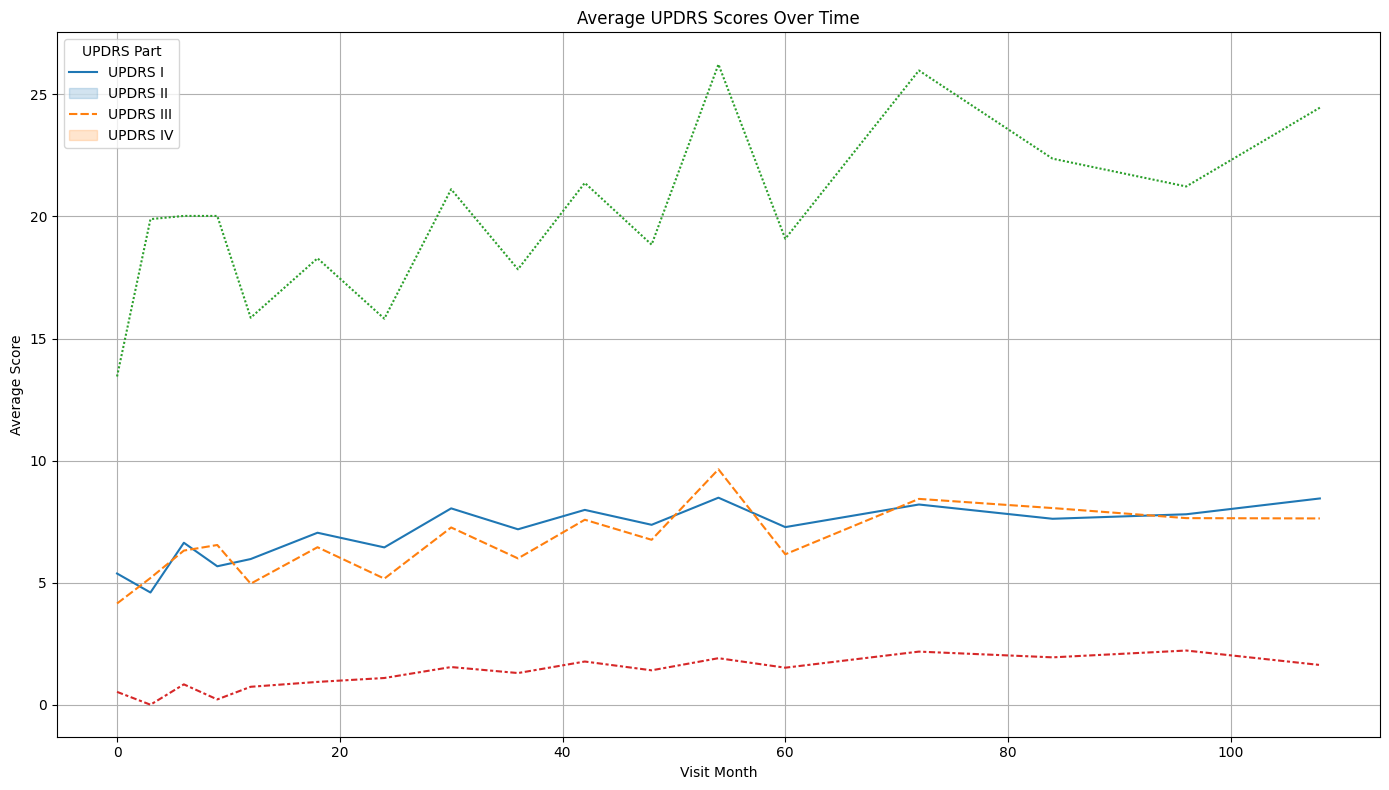

In [5]:
# Group by visit_month and compute the mean for each UPDRS score
avg_updrs_scores_over_time = train_clinical_data.groupby('visit_month').mean()[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]

# Plotting the average UPDRS scores over time
plt.figure(figsize=(14, 8))
sns.lineplot(data=avg_updrs_scores_over_time)
plt.title('Average UPDRS Scores Over Time')
plt.ylabel('Average Score')
plt.xlabel('Visit Month')
plt.legend(title='UPDRS Part', labels=['UPDRS I', 'UPDRS II', 'UPDRS III', 'UPDRS IV'])
plt.grid(True)
plt.tight_layout()
plt.show()

##### Observations:

* The scores for UPDRS Parts I, II, and IV seem relatively stable over time.
* UPDRS Part III (Motor Examination) shows some variability, with a noticeable increase around the 20th month and then a decline.
* The variability in UPDRS Part III might indicate fluctuations in motor symptoms experienced by the cohort during that time period.

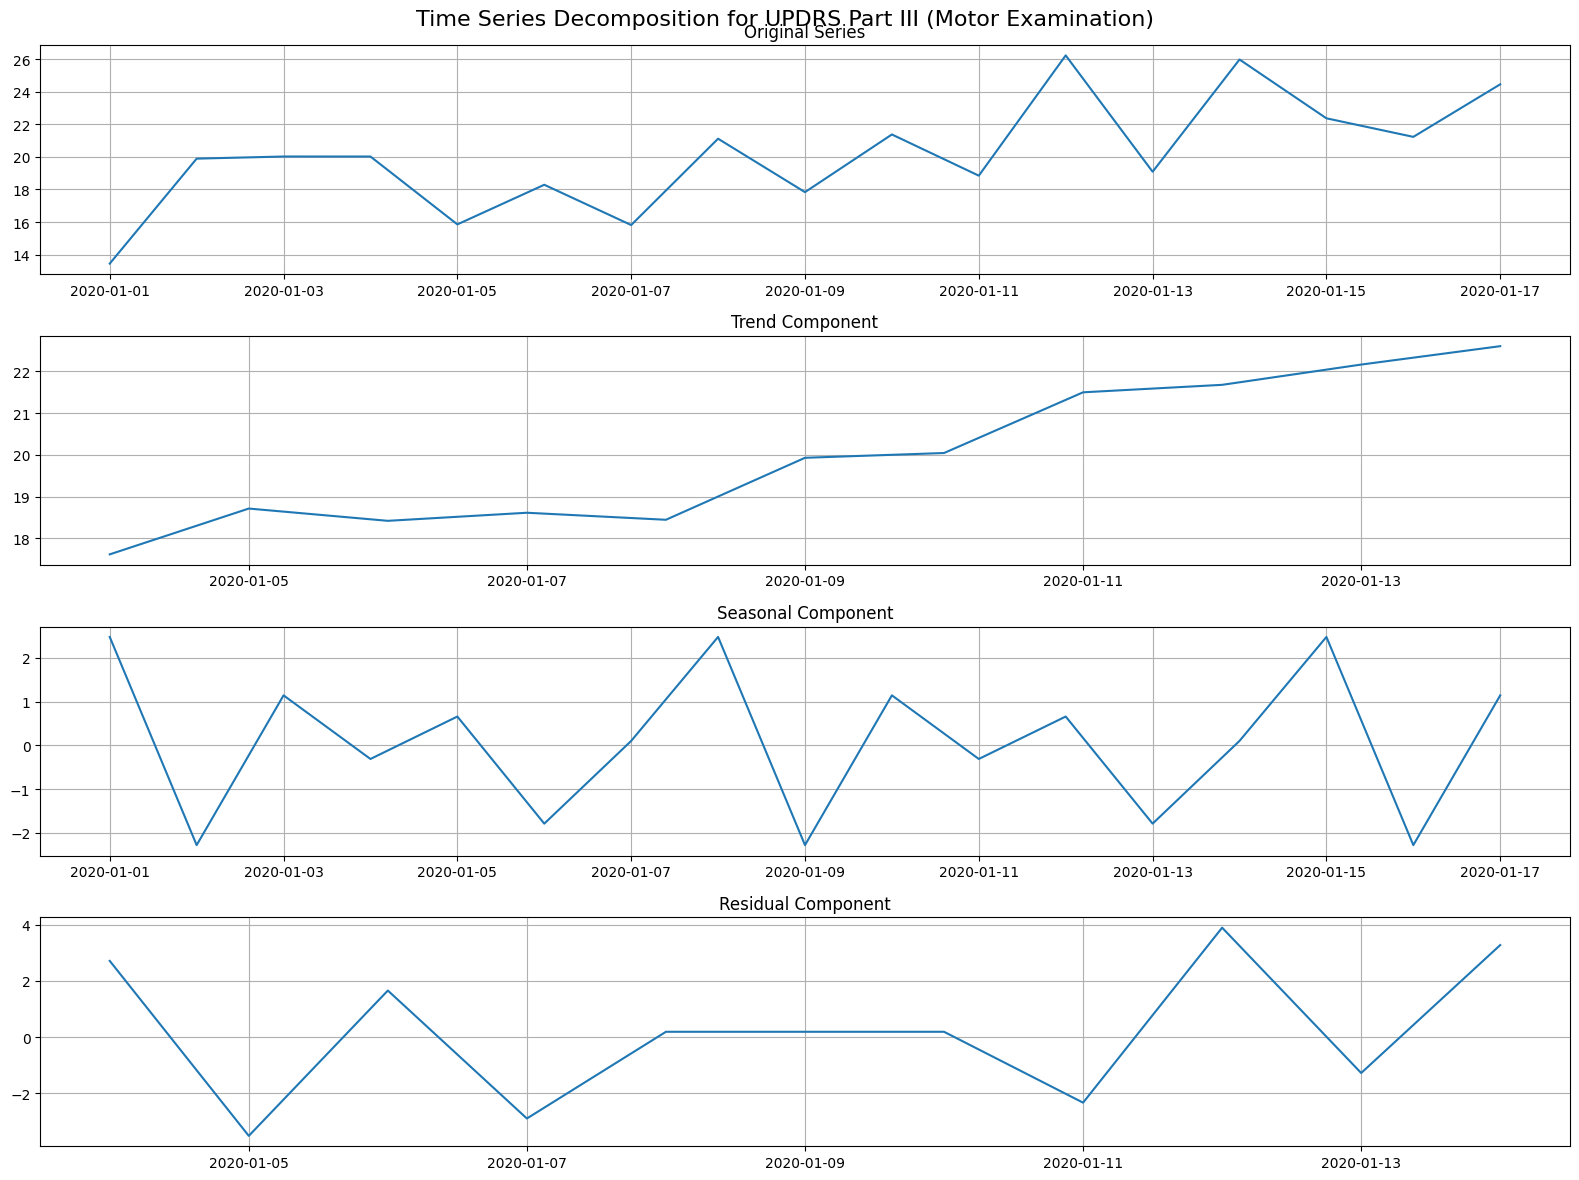

In [12]:
# Setting a monthly frequency for the time series data
avg_updrs_scores_over_time.index = pd.date_range(start='1/1/2020', periods=len(avg_updrs_scores_over_time), freq='D')#freq='M') monthly when we have more data

# Decomposing the time series data for UPDRS Part III with the assumed daily frequency
decomposition = seasonal_decompose(avg_updrs_scores_over_time['updrs_3'], model='additive')

# Plotting the decomposition
plt.figure(figsize=(16, 12))
plt.suptitle('Time Series Decomposition for UPDRS Part III (Motor Examination)', fontsize=16)

# Original series
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Original Series')
plt.grid(True)

# Trend component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend Component')
plt.grid(True)

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')
plt.grid(True)

# Residual component
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual Component')
plt.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


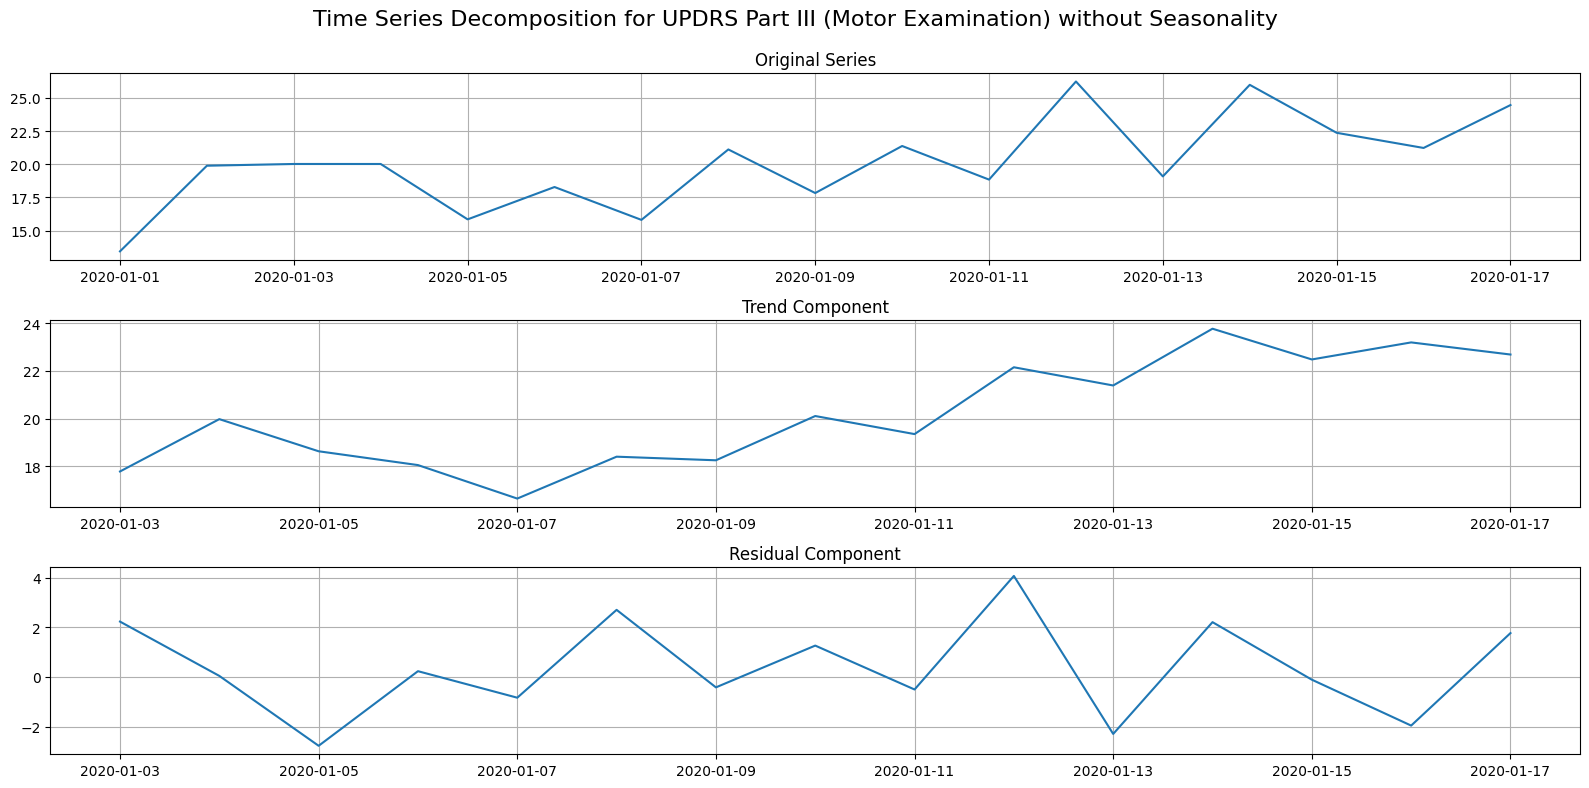

In [11]:
# Decomposing the time series data for UPDRS Part III without the seasonal component
# We'll use a naive approach by subtracting the trend from the original series to get the residuals
trend = avg_updrs_scores_over_time['updrs_3'].rolling(window=3).mean()  # Using a simple rolling mean as the trend
residual = avg_updrs_scores_over_time['updrs_3'] - trend

# Plotting the decomposition without seasonal component
plt.figure(figsize=(16, 8))
plt.suptitle('Time Series Decomposition for UPDRS Part III (Motor Examination) without Seasonality', fontsize=16)

# Original series
plt.subplot(3, 1, 1)
plt.plot(avg_updrs_scores_over_time['updrs_3'])
plt.title('Original Series')
plt.grid(True)

# Trend component
plt.subplot(3, 1, 2)
plt.plot(trend)
plt.title('Trend Component')
plt.grid(True)

# Residual component
plt.subplot(3, 1, 3)
plt.plot(residual)
plt.title('Residual Component')
plt.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()


* Original Series: Displays the UPDRS Part III scores over time.
* Trend Component: A rolling mean was used to capture the underlying trend in the data. This shows the general direction in which the scores are moving over time.
* Residual Component: Represents the deviations from the trend, capturing any sudden spikes or drops.

From the decomposition, we see that there's a general upward trend in the UPDRS Part III scores, indicating worsening motor symptoms over the months. The residuals, meanwhile, give us a sense of the variability around this trend.

In [ ]:
# Splitting the data into training and test sets
train_size = int(len(avg_updrs_scores_over_time['updrs_3']) * 0.75)
train, test = avg_updrs_scores_over_time['updrs_3'][:train_size], avg_updrs_scores_over_time['updrs_3'][train_size:]

# Training the ARIMA model
# Using a simple (1,1,1) order for the ARIMA model as a starting point
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit(disp=0)

# Predicting on the test set
forecast, stderr, conf_int = model_fit.forecast(steps=len(test))

# Calculating the Mean Squared Error for the forecasts
mse = mean_squared_error(test, forecast)

forecast_series = pd.Series(forecast, index=test.index)

mse, forecast_series

In [ ]:
# saving the model to the local file system
filename = 'data/finalized_model.sav'
pickle.dump(refined_grid_search, open(filename, 'wb'))    
#saving the scaler
filename = 'data/finalized_scaler.sav'
pickle.dump(scaler, open(filename, 'wb'))
